In [6]:
from numpy import mean
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from HAdam import HAdam
from HAdamax import HAdamax
from HAdamWDemon import HAdamWDemon

In [2]:
args={}
kwargs={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

In [19]:
print(len(train_loader)*args['batch_size'])
print(len(test_loader)*args['test_batch_size'])

60000
10000


In [4]:
#Source: https://nextjournal.com/gkoehler/pytorch-mnist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [7]:
network = Net()
n_epochs = 10
optimizer1 = torch.optim.Adam(network.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
#optimizer2 = HAdam(network.parameters(), lr=0.0002, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.01, k = 4)
#optimizer3 = HAdam(network.parameters(), lr=0.0002, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.01, k = 8)
optimizer4 = HAdamWDemon(network.parameters(), n_epochs, len(train_loader), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, k=2)
#optimizer6 = HAdamWDemon(network.parameters(), n_epochs, len(train_loader), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, k=4)
#optimizer7 = HAdamWDemon(network.parameters(), n_epochs, len(train_loader), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, k=8)
#optimizer5 = HAdam(network.parameters(), lr=0.0002, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.0005, k = 2)
optimizer8 = torch.optim.AdamW(network.parameters(), lr=0.0002, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01)
#optimizer4 = HAdamax(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, k = 4)
#optimizers = [optimizer1, optimizer2, optimizer3]
optimizer9 = HAdamWDemon(network.parameters(), n_epochs, len(train_loader), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00, k=2)
optimizers = [optimizer1, optimizer8, optimizer9, optimizer4]

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
network.to(device)

n_epochs = 10
train_losses = []
test_losses = []

for i, optimizer in enumerate(optimizers):
    network.apply(weight_reset)
    train_loss = []
    test_loss = []
    
    for e in range(n_epochs):
        epoch_test_loss = []
        network.train()
        batch_idx = 1
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            out = network(images)
            loss = F.nll_loss(out, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            if (batch_idx % 100 == 0):
                print(loss.item())
            batch_idx += 1
        
        network.eval()
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            out = network(images)
            loss = F.nll_loss(out,targets)
            epoch_test_loss.append(loss.item())
        test_loss.append(mean(epoch_test_loss))
        
        
    train_losses.append(train_loss)
    test_losses.append(test_loss)

<ipython-input-4-47b4c405f662>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


1.8526300191879272
1.072860836982727
0.8188310861587524
0.8125402331352234
0.554749608039856
0.7908753156661987
0.6254339814186096
0.3604098856449127
0.4069058299064636
0.38539329171180725
0.44691821932792664
0.4441182017326355
0.39561912417411804
0.42521652579307556
0.22551965713500977
0.3033694624900818
0.39089062809944153
0.2774716913700104
0.28200453519821167
0.4232589304447174
0.29360154271125793
0.43884003162384033
0.4312264919281006
0.39273586869239807
0.22188955545425415
0.2922773063182831
0.4655449688434601
0.23671016097068787
0.31900879740715027
0.18078067898750305
0.24367420375347137
0.3010839521884918
0.19441121816635132
0.25903570652008057
0.2903673052787781
0.205068439245224
0.2004271000623703
0.24667418003082275
0.3168600797653198
0.21273761987686157
0.2508316934108734
0.11763152480125427
0.1752873659133911
0.27601516246795654
0.3519650995731354
0.34729620814323425
0.15988677740097046
0.17528672516345978
0.2021380215883255
0.14673694968223572
0.24469012022018433
0.430412

Text(0.5, 0, 'Epoch')

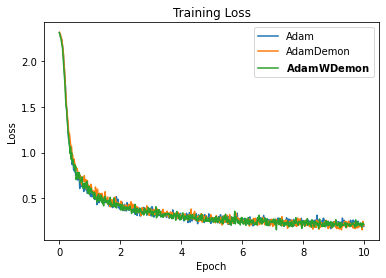

In [15]:
import matplotlib as mpl

x_train =  [x / len(train_loader.dataset)*args['batch_size'] for x in range(len(train_losses[1]))]

for i in range(len(train_losses)):
    if i != 1:
        data = [ mean(train_losses[i][j*10:(j+1)*10]) for j in range(int(len(x_train)/10))]
        x_data = [x / len(data) * n_epochs for x in range(len(data))]
        mpl.pyplot.plot(x_data, data)
#mpl.pyplot.legend(['Adam Train Loss', 'HAdam Train Loss (k=4)', 'HAdam Train Loss (k=8)'])
mpl.pyplot.legend(['Adam', 'AdamDemon', r"$\bf{AdamWDemon}$"])
mpl.pyplot.title("Training Loss")
mpl.pyplot.ylabel("Loss")
mpl.pyplot.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

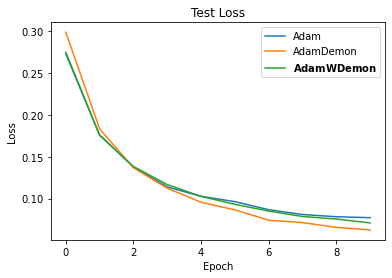

In [13]:
for i in range(len(test_losses)):
    if i != 1:
        mpl.pyplot.plot(range(len(test_losses[i])), test_losses[i])
mpl.pyplot.legend(['Adam', 'AdamDemon', r"$\bf{AdamWDemon}$"])
mpl.pyplot.title("Test Loss")
mpl.pyplot.ylabel("Loss")
mpl.pyplot.xlabel("Epoch")

In [9]:
print(len(train_loader))
print(len(train_loader.dataset))

60
60000
